# SHARPENING (HIGHPASS) SPATIAL FILTERS

In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

上一部分介绍的blur能够将图片模糊化, 这部分介绍的是突出图片的边缘的细节.

什么是边缘呢? 往往是像素点跳跃特别大的点, 这部分和梯度的概念是类似的, 可以如下定义图片的一阶导数而二阶导数:
$$
\frac{\partial f}{\partial x} = f(x+1) - f(x), \\
\frac{\partial^2 f}{\partial x^2}  = f(x+1) + f(x-1) - 2f(x).
$$
注: 或许用差分来表述更为贴切.



![image-20210616163224376](https://i.loli.net/2021/06/16/Tc7uPWZhHiAq6rD.png)

如上图实例所示, 描述了密度值沿着$x$的变化, 一阶导数似乎能划分区域, 而二阶导数能够更好的“识别"边缘.

## Laplacian



著名的laplacian算子:
$$
\Delta f = \frac{\partial^2 f}{\partial x^2} + \frac{\partial^2 f}{\partial y^2},
$$
在digital image这里:
$$
\Delta f = f(x+1， y) + f(x-1, y) + f(x, y+1) + f(x, y-1) - 4 f(x, y).
$$


这个算子用kernel表示是下面的(a), 但是在实际中也有(b, c, d)的用法, (b, d)额外用到了对角的信息, 注意到这些kernels都满足
$$
\sum_{ij}w_{ij} = 0.
$$


![image-20210616164037264](https://i.loli.net/2021/06/16/E2Pb8aBMulFxRKs.png)

In [89]:
img = cv2.imread("./pics/moon.png")
img.shape

(485, 416, 3)

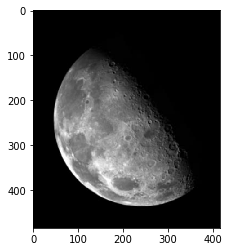

In [90]:
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) # 由于是截图, 先转成灰度图
img = img.astype(np.float32)
plt.imshow(img, cmap='gray')

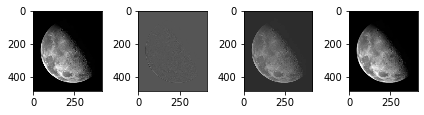

In [95]:
kernel = -np.ones((3, 3))
kernel[1, 1] = 8
laps = cv2.filter2D(img, -1, kernel)
laps = (laps - laps.min()) / (laps.max() - laps.min()) * 255
img_pos = img + laps
img_neg = img - laps
fig, axes = plt.subplots(1, 4)
axes[0].imshow(img, cmap='gray')
axes[1].imshow(laps, cmap='gray')
axes[2].imshow(img_pos, cmap='gray')
axes[3].imshow(img_neg, cmap='gray')
plt.tight_layout()
plt.show()

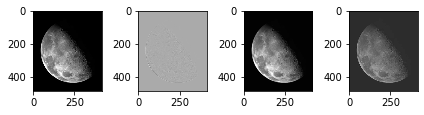

In [96]:
kernel = np.ones((3, 3))
kernel[0, 0] = 0
kernel[0, 2] = 0
kernel[1, 1] = -4
kernel[2, 0] = 0
kernel[2, 2] = 0
laps = cv2.filter2D(img, -1, kernel)
laps = (laps - laps.min()) / (laps.max() - laps.min()) * 255
img_pos = img + laps
img_neg = img - laps
fig, axes = plt.subplots(1, 4)
axes[0].imshow(img, cmap='gray')
axes[1].imshow(laps, cmap='gray')
axes[2].imshow(img_pos, cmap='gray')
axes[3].imshow(img_neg, cmap='gray')
plt.tight_layout()
plt.show()

## UNSHARP MASKING AND HIGHBOOST FILTERING





注意到, 之前的box kernel,
$$
w_{box}(s, t) = \frac{1}{mn},
$$
考虑$3 \times 3$的kernel size下:
$$
w_{lap} = 9(E -  \cdot w_{box}),
$$
这里
$$
E(s, t) =0, \forall s\not=2, t\not=2.
$$
故假设
$$
g_{mask} (x, y) = f(x, y) - \bar{f} (x, y),
$$
其中$\bar{f}$是通过box filter 模糊的图像, 则
$$
\Delta f = 9 \cdot g_{mask}.
$$
故$g_{mask}$也反应了细节边缘信息.

进一步定义
$$
g(x, y) = f(x, y) + k g_{mask}(x, y).
$$


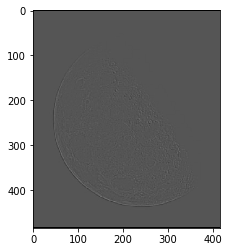

In [100]:
kernel = np.ones((3, 3)) / 9
img_mask = (img - cv2.filter2D(img, -1, kernel)) * 9
img_mask = (img_mask - img_mask.mean()) / (img_mask.max() - img_mask.min())
fig, ax = plt.subplots(1, 1)
ax.imshow(img_mask, cmap='gray')
plt.show()

## First-Order Derivatives



最后再说说如何用一阶导数提取细节.



定义
$$
M(x, y) = \|\nabla f\| = \sqrt{(\frac{\partial f}{\partial x})^2 + (\frac{\partial f}{\partial y})^2}.
$$
注: 也常常用$M(x, y) = |\frac{\partial f}{\partial x}| + |\frac{\partial f}{\partial y}|$代替.

![image-20210616191901456](https://i.loli.net/2021/06/16/DlJ4IHrxsCE8dqj.png)



### Roberts cross-gradient

把目标区域按照图(a)区分, Roberts cross-gradient采用如下方式定义:
$$
\frac{\partial f}{\partial x} = z_9 - z_5, \: \frac{\partial f}{\partial y} = z_8 - z_6,
$$
即右下角的对角之差. 所以相应的kernel变如图(b, c)所示(其余部分为0, $3 \times 3$).

注: 计算$M$需要两个kernel做两次卷积.



### Sobel operators



Sobel operators 则是
$$
\frac{\partial f}{\partial x} = (z_7 + 2z_8 + z_9) - (z_1 + 2z_2 + z_3) \\
\frac{\partial f}{\partial y} = (z_3 + 2z_6 + z_9) - (z_1 + 2z_4 + z_7),
$$
即如图(d, e)所示.



In [116]:
kernel = np.zeros((3, 3))
kernel[1, 1] = -1
kernel[2, 2] = 1
part1 = cv2.filter2D(img, -1, kernel)
kernel = np.zeros((3, 3))
kernel[1, 2] = -1
kernel[2, 1] = 1
part2 = cv2.filter2D(img, -1, kernel)
img_roberts = np.sqrt(part1 ** 2 + part2 ** 2)

In [117]:
part1 = cv2.Sobel(img, -1, dx=1, dy=0, ksize=3)
part2 = cv2.Sobel(img, -1, dx=0, dy=1, ksize=3)
img_sobel = np.sqrt(part1 ** 2 + part2 ** 2)

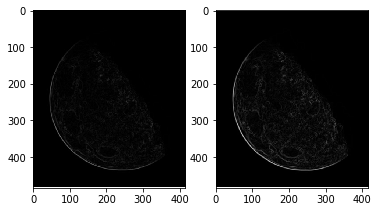

In [118]:
fig, axes = plt.subplots(1, 2)
axes[0].imshow(img_roberts, cmap='gray')
axes[1].imshow(img_sobel, cmap='gray')